In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame as df
from pyens.models import Flywheel, OCV, EcmCell
from pyens.utilities import ivp
from pyens.simulations import Data, Current, Learner,Simulator
import os
import matplotlib.pyplot as plt

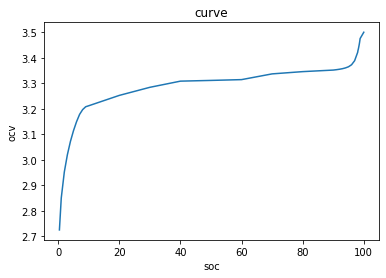

In [2]:

ocv = [
    2.725578,
    2.850545,
    2.952456,
    3.020007,
    3.072155,
    3.114243,
    3.149442,
    3.178211,
    3.196915,
    3.208162,
    3.21203,
    3.252616,
    3.284272,
    3.308415,
    3.311269,
    3.314391,
    3.336869,
    3.345692,
    3.351787,
    3.353211,
    3.354968,
    3.357175,
    3.360247,
    3.364758,
    3.372647,
    3.388452,
    3.421374,
    3.428617,
    3.433137,
    3.438826,
    3.444884,
    3.4514,
    3.458486,
    3.466429,
    3.475249,
    3.5,
]
soc = [
    0.397351,
    1,
    2,
    3,
    4,
    5,
    6,
    7,
    8,
    9,
    10,
    20,
    30,
    40,
    50,
    60,
    70,
    80,
    90,
    91,
    92,
    93,
    94,
    95,
    96,
    97,
    98,
    98.1,
    98.2,
    98.3,
    98.4,
    98.5,
    98.6,
    98.7,
    98.8,
    100.0,
]

c1 = OCV(name="curve1", ocv=ocv, soc=soc)

c1.display()

the training dataset has a gap , during which the cell is relaxing,

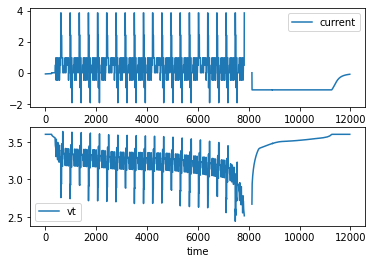

In [3]:

TESTDATA_FILEPATH = os.path.join(os.path.dirname(os.getcwd()),
'tests/cycling/main-data-as-seriestocolumns-2022-08-05 15_37_19.xlsx')

# data come from https://web.calce.umd.edu/batteries/data.htm

schema = {
    "Time": "time",
    "Cell_LFP_CALCE_A1_007.max_current": "current",
    "Cell_LFP_CALCE_A1_007.max_v_tr": "vt",
    "rsv_i_dir": False,
}
d1 = Data(name="d1", df=None)
d1.fetch_file(TESTDATA_FILEPATH, schema=schema)
d1.to_abs_time()
d1.disp()

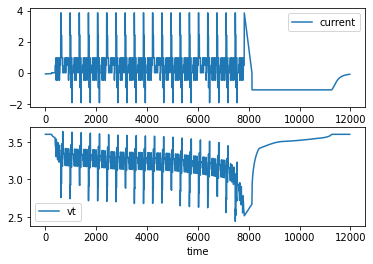

In [4]:
d1.df.interpolate(method='linear',inplace=True)
d1.df.dropna(inplace=True)
d1.disp()

In [5]:
d1.df.reset_index(inplace=True)

In [6]:
param_sim = {
    "R0": 0.1,
    "R1": 0.1,
    "tau1": 2,
    "R2": 0.1,
    "tau2": 1,
    "CAP": 1.1,
    "ce": 0.99,
    "v_limits": [1.5, 4.5],
    "SOC_RANGE": [0.0, 100.0],
}
m_sim = EcmCell(name="cell_model_sim", parameters=param_sim, curve=c1)
l2 = Learner(name="l2")
l2.attach(d1).attach(m_sim)
x0_sim = np.array([-0.05, -0.05, 100])

config = {
    "solver_type": "adaptive",
    "solution_name": "sol1",
    "max_step":np.inf,
    'maxiter':50,
    'method':'Powell'}

method = "diff"
bounds=(
    (1e-4, 1),
    (1e-4, 1),
    (1, 10),
    (1e-4, 1),
    (1, 10),
    (0.9, 1.2),
)


In [7]:
res = l2.fit_parameters(("cell_model_sim", "d1"), config, x0_sim, method,bounds)
print('the extracted R0 is {}, R1 is {}, C1 is {}, R2 is {}, C2 is {}, CAP is {}'.format(*res.x))
print('tau1 is {} min'.format(res.x[2]))
print('tau2 is {} hours'.format(res.x[4]))

/workspaces/pyens/.venv/lib/python3.10/site-packages/scipy/optimize/_differentialevolution.py:377: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  with DifferentialEvolutionSolver(func, bounds, args=args,


differential_evolution step 1: f(x)= 0.0202511
differential_evolution step 2: f(x)= 0.0202511
differential_evolution step 3: f(x)= 0.0202511
differential_evolution step 4: f(x)= 0.0202511
differential_evolution step 5: f(x)= 0.0169724
differential_evolution step 6: f(x)= 0.0159495
differential_evolution step 7: f(x)= 0.0159495
differential_evolution step 8: f(x)= 0.0159495
differential_evolution step 9: f(x)= 0.0159495
differential_evolution step 10: f(x)= 0.0105367
differential_evolution step 11: f(x)= 0.0105367
differential_evolution step 12: f(x)= 0.00992997
differential_evolution step 13: f(x)= 0.00992997
differential_evolution step 14: f(x)= 0.00992997
differential_evolution step 15: f(x)= 0.00992997
differential_evolution step 16: f(x)= 0.00992997
differential_evolution step 17: f(x)= 0.00992997
differential_evolution step 18: f(x)= 0.00992997
differential_evolution step 19: f(x)= 0.00992997
differential_evolution step 20: f(x)= 0.00992997
differential_evolution step 21: f(x)= 0.

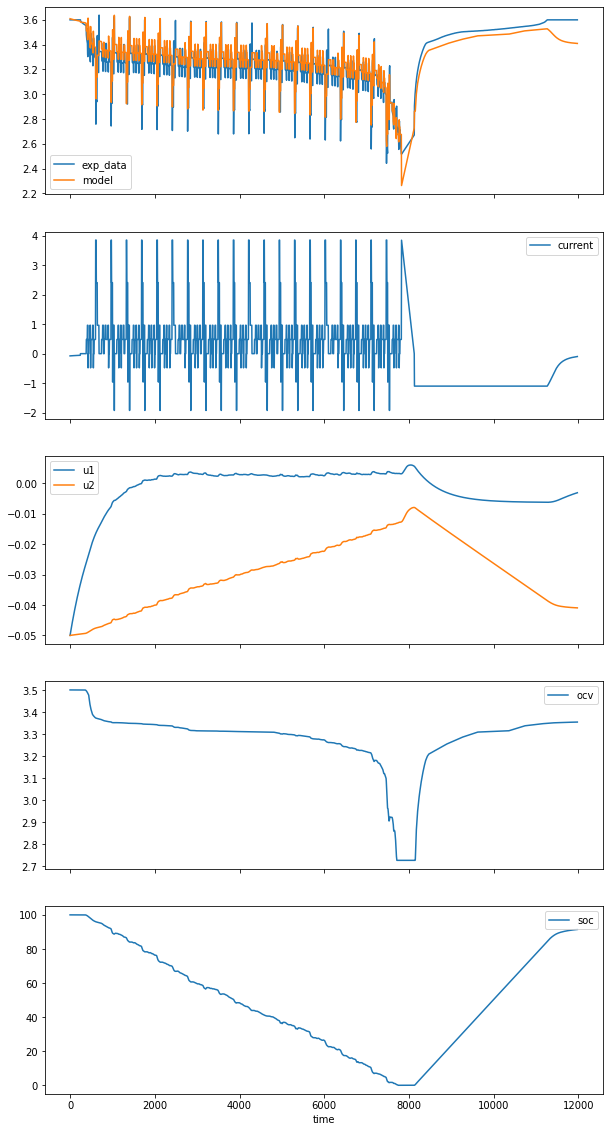

In [10]:
param_exr = {
    "R0": res.x[0],
    "R1": res.x[1],
    "tau1": res.x[2],
    "R2": res.x[3],
    "tau2": res.x[4],
    "CAP": res.x[5],
    "ce": 0.99,
    "v_limits": [1.5, 4.5],
    "SOC_RANGE": [0.0, 100.0],
}

m_exr = EcmCell(name="cell_model_exr", parameters=param_exr, curve=c1)

s3 = Simulator(name="s3")
s3.attach(d1).attach(m_exr)
d3 = s3.run(("cell_model_exr", "d1"), x0_sim)

fig,  ax = plt.subplots(5,1,sharex=True,figsize=(10,20))

# ax[0].set_ylim(bottom=2.5,top=3.8)
# ax[0].set_ylim(bottom=-.75,top=.1)
d1.df.plot(ax=ax[0],x='time',y='vt',label='exp_data')
d3.df.plot(ax=ax[0],x='time',y='vt',label='model' )
d1.df.plot(ax=ax[1],x='time',y='current',label='current')
d3.df.plot(ax=ax[2],x='time',y='u1',label='u1')
d3.df.plot(ax=ax[2],x='time',y='u2',label='u2')
d3.df.plot(ax=ax[3],x='time',y='ocv',label='ocv')
d3.df.plot(ax=ax[4],x='time',y='soc',label='soc')
plt.show()
